# ResNet-50 + SVM

This notebook used to train the parking lot classifier. ResNet-50 is used as feature extractor and SGDClassifier (linear Support Vector Machine) is trained on the extracted features

Features are extracted separately using extract_features_from_images.py file

In [1]:
import numpy as np
np.random.seed(143)
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold 

%matplotlib inline

In [2]:
label2idx = {
    'Empty': 0,
    'Occupied': 1
}

In [3]:
def read_features(feature_path):
    if os.path.exists(feature_path):
        with open(feature_path, 'r') as features_file:
            features_str = features_file.read()
        features = [float(x) for x in features_str.split(',')]
        label = feature_path.split("~")[-2]
    
    return features, label2idx[label]

In [4]:
train = "../vkda/pklot_dataset/features/resnet50/train/*.txt"
valid = "../vkda/pklot_dataset/features/resnet50/valid/*.txt"

In [6]:
# Creat validation dataset
valid_x = []
valid_y = []
for f in glob(valid):
    x, y = read_features(f)
    valid_x.append(x)
    valid_y.append(y)
valid_x = np.asarray(valid_x)
valid_y = np.asarray(valid_y)

In [7]:
# Create training dataset
train_x = []
train_y = []
for feature_file in glob(train):
    x, y = read_features(feature_file)
    train_x.append(x)
    train_y.append(y)
train_x = np.asarray(train_x)
train_y = np.asarray(train_y) 

### Fit the model on training dataset

#### To train the model in batch mode

For large datset, Support Vector Classifer or SGDClassifer fit() will take long time to train. To train the model in batch mode, please use the below cell and skip others

In [2]:
# size = len(glob(train))
# train_x = glob(train)
# batch_size = 100
# steps = size // batch_size

# # Linear SVM classifier
# clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

# for idx in range(steps+1):
#     print("Step: ", idx+1)
#     mini_train_x = train_x[idx*batch_size: (idx+1)*batch_size]
#     X = []
#     Y = []
#     for feature_file in mini_train_x:
#         x, y = read_features(feature_file)
#         X.append(x)
#         Y.append(y)
#     X = np.asarray(X)
#     Y = np.asarray(Y)
#     clf.partial_fit(X, Y, classes=np.asarray([0,1]))
#     # Evaluate the model on validation dataset
#     print("Validation accuracy: ", clf.score(valid_x, valid_y))

#### To train the model in normal mode

To train the model in full dataset without using partial fit()

In [9]:
# Initialize the model with loss tolerance 1e-3
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

In [10]:
# Create 5-fold cross validation split index
kf = KFold(n_splits=5, random_state=187, shuffle=False)

In [11]:
cv_score = []
for train_index, test_index in kf.split(train_x):
    train_x_fold, test_x_fold = train_x[train_index], train_x[test_index]
    train_y_fold, test_y_fold = train_y[train_index], train_y[test_index]
    
    clf.fit(train_x_fold, train_y_fold)
    score_fold = clf.score(test_x_fold, test_y_fold)
    cv_score.append(score_fold)

print("Cross validation score: ", round(sum(cv_score)/5, 3))

Cross validation score:  0.997


### Evaluate the model metrics on validation dataset

In [12]:
# Mean accuracy score
print("Validation score: ", round(clf.score(valid_x, valid_y), 3))

Validation score:  0.985


In [13]:
# Generate predictions on validation dataset
valid_pred = clf.predict(valid_x)

In [14]:
print(classification_report(valid_y, valid_pred, target_names=['Empty', 'Occupied']))

             precision    recall  f1-score   support

      Empty       0.99      0.98      0.99     22980
   Occupied       0.98      0.99      0.98     19404

avg / total       0.99      0.99      0.99     42384



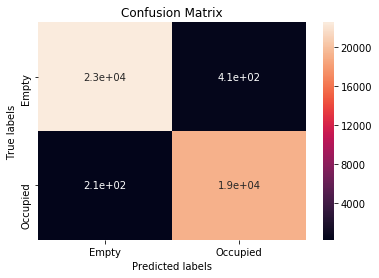

In [15]:
# confusion matrix
cm = confusion_matrix(valid_y, valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

In [19]:
print(cm)

[[22573   407]
 [  214 19190]]


### Save model

In [16]:
import pickle as pkl

In [17]:
model_name = "resnet50_linear_svm.h5"
pkl.dump(clf, open(model_name, 'wb'))

### Load and validate the model

In [18]:
loaded_model = pkl.load(open(model_name, 'rb'))
print(classification_report(valid_y, valid_pred, target_names=['Empty', 'Occupied']))

             precision    recall  f1-score   support

      Empty       0.99      0.98      0.99     22980
   Occupied       0.98      0.99      0.98     19404

avg / total       0.99      0.99      0.99     42384

